# Causal Inference in Internal space with Angle space responses

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import vonmises, circmean
from custom_causal_inference import CustomCausalInference
from repulsion_hypothesis import repulsion_value
import utils
import plots
import forward_models_causal_inference

## Setup

In [ ]:
num_sim = 1000
D = 250  # grid dimension 
angle_gam_data_path = 'D:/AK_Q1_2024/Gatsby/data/base_bayesian_contour_1_circular_gam/base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='D:/AK_Q1_2024/Gatsby/uniform_model_base_inv_kappa_free.pkl'
p_commons = [0, .2, .5, .7, 1]

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

Get the s_n, t, r_n(s_n, t) values of interest

In [7]:
s_n, t, r_n = utils.get_s_n_and_t(causal_inference_estimator.grid, 
                                   causal_inference_estimator.gam_data)
s_n.shape, t.shape, r_n.shape

((250, 250), (250, 250), (250, 250))

Further filer the values of s_n, t considered (and r_n implicitly) for faster simulations

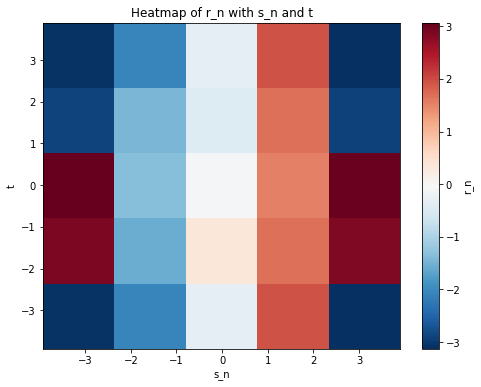

<Figure size 432x288 with 0 Axes>

In [8]:
num_means = 4
step=len(s_n)//num_means
indices = np.arange(0, s_n.shape[0], step=step)
mu_x_dim = len(indices)
s_n = s_n[indices][:, indices]
t = t[indices][:, indices]
r_n = r_n[indices][:, indices]
plots.heatmap_f_s_n_t(f_s_n_t=r_n, s_n=s_n, t=t, f_name='r_n')

In [9]:
s_n.shape, t.shape

((5, 5), (5, 5))

## Causal inference

### Convert means to internal space and choose the concentrations to be analysed for each

In [9]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
kappa1 = np.array([20, 50, 70, 100])
kappa2 = np.array([10, 40, 60, 90])
print(f'Performing causal inference for ut, u_s_n of shape {ut.shape, us_n.shape}')

Performing causal inference for ut, u_s_n of shape ((25,), (25,))


### Simulate the inference by sampling the 2 internal estimates for each pair of means (and associated concentrations)

In [10]:
results = {
    'responses': [], 
    'posterior_p_common': [],
    'mean_t_est': [], 
    'mean_sn_est': []
}
results['num_sim'] = 10000
results['ut'] = ut
results['us_n'] = us_n
t_samples, s_n_samples = causal_inference_estimator.get_vm_samples(num_sim=results['num_sim'], 
                                                                    mu_t=ut, mu_s_n=us_n,
                                                                    kappa1=kappa1, 
                                                                    kappa2=kappa2)

In [11]:
t_samples.shape, s_n_samples.shape

((10000, 25, 4), (10000, 25, 4))

In [ ]:
for p_common in p_commons:
    responses, posterior_p_common, mean_t_est, mean_sn_est = causal_inference_estimator.forward(t_samples=t_samples,
                                                                                                s_n_samples=s_n_samples,
                                                                                                p_common=p_common,
                                                                                                kappa1=kappa1,
                                                                                                kappa2=kappa2)
    results['responses'].append(responses)
    results['posterior_p_common'].append(posterior_p_common)
    results['mean_t_est'].append(mean_t_est)
    results['mean_sn_est'].append(mean_sn_est)

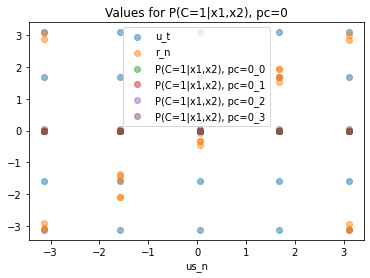

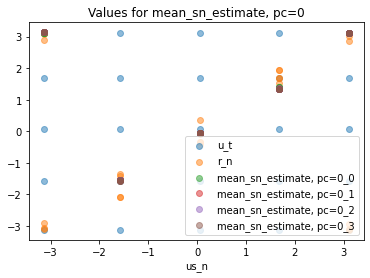

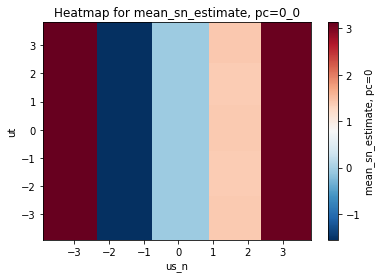

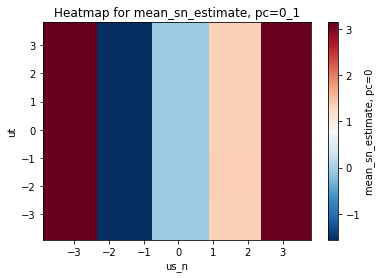

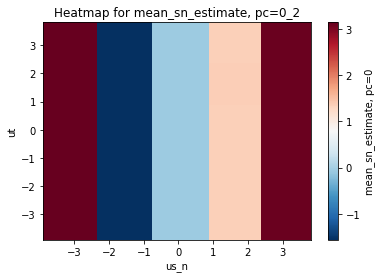

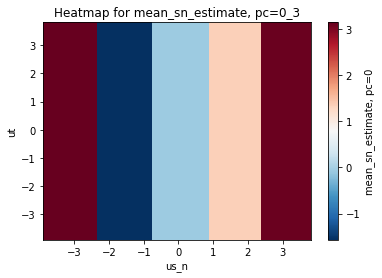

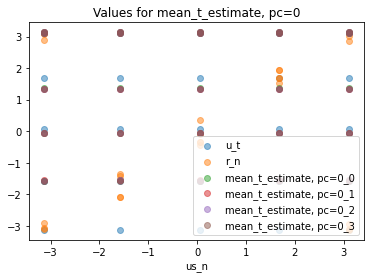

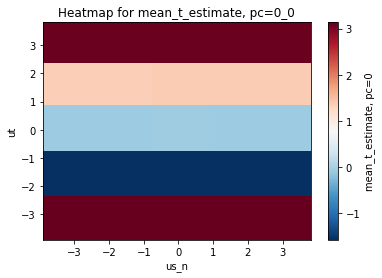

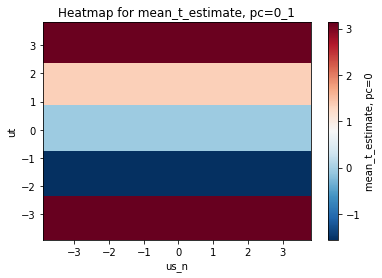

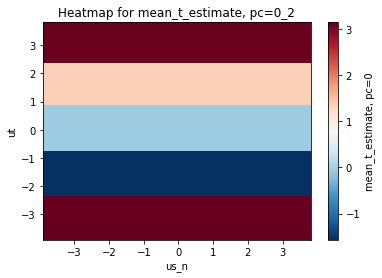

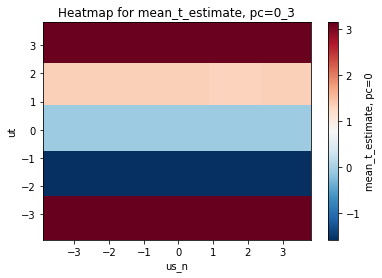

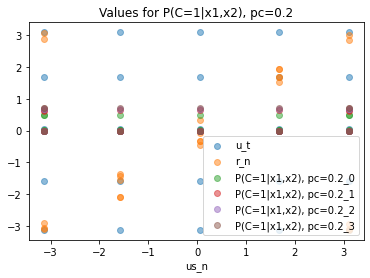

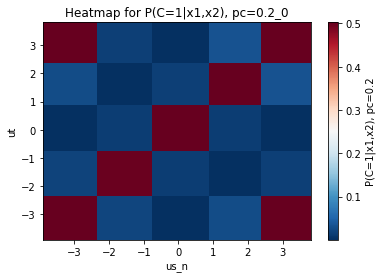

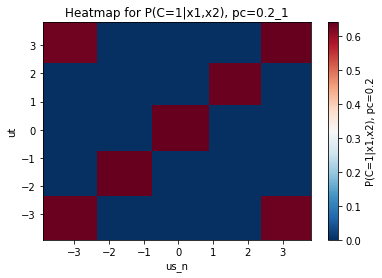

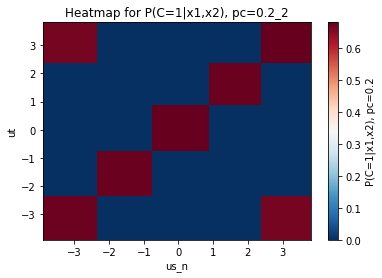

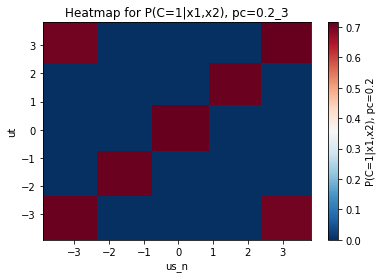

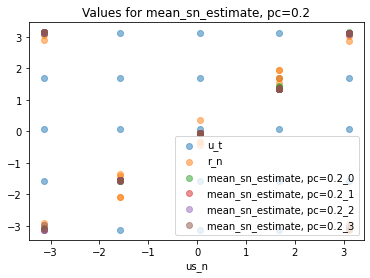

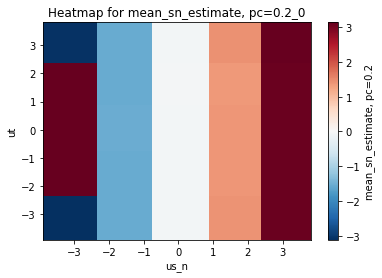

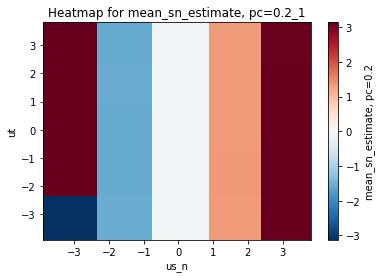

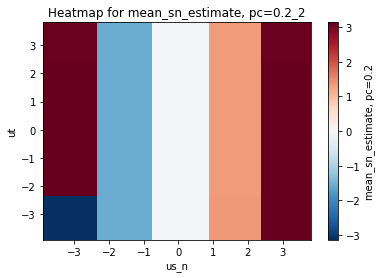

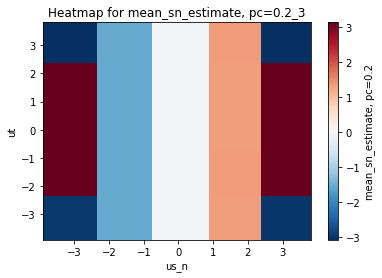

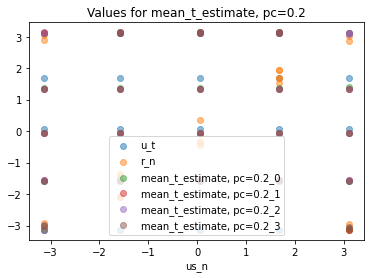

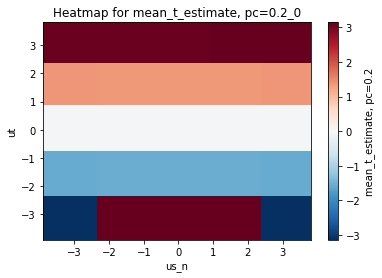

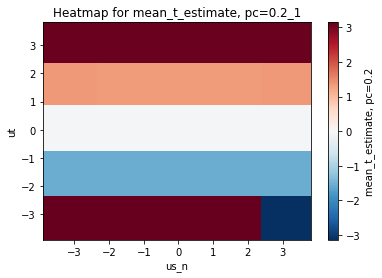

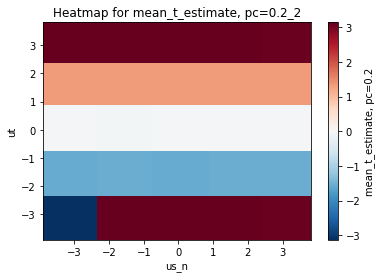

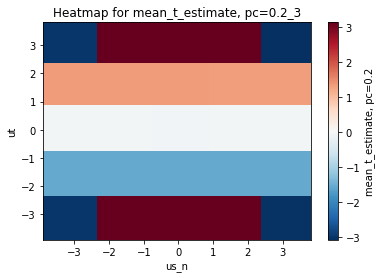

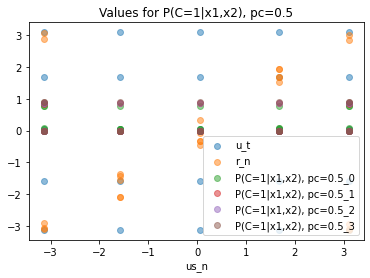

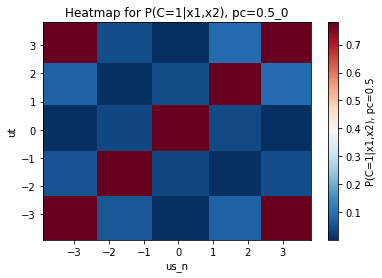

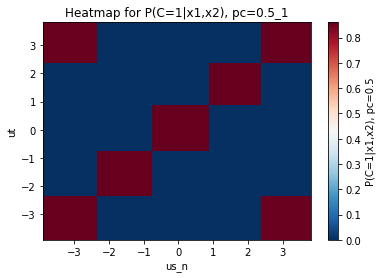

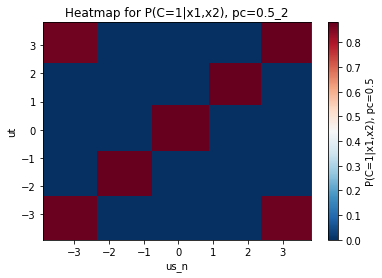

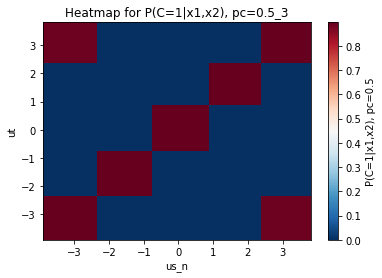

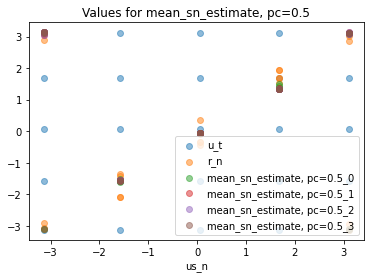

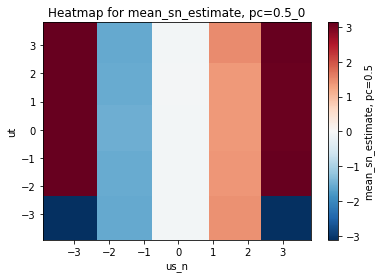

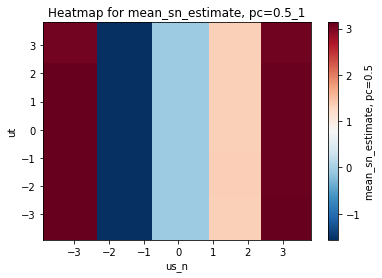

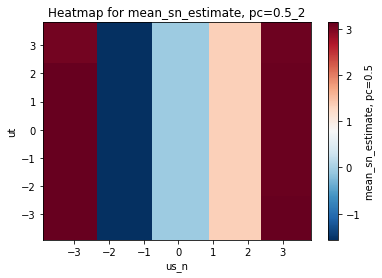

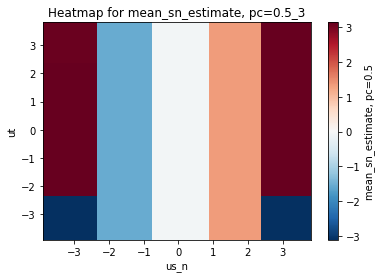

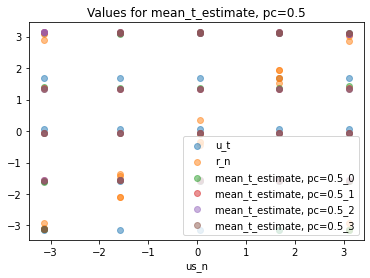

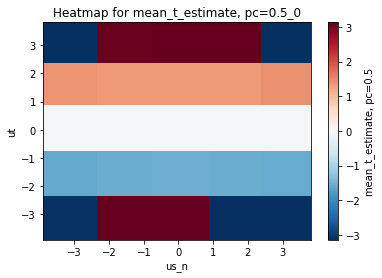

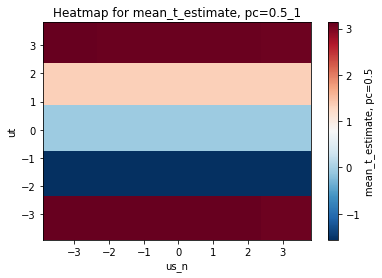

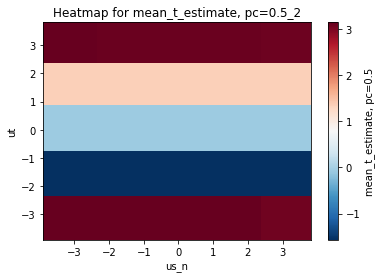

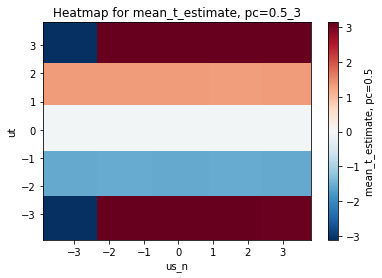

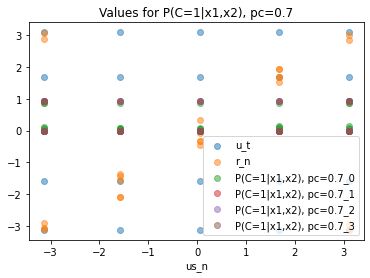

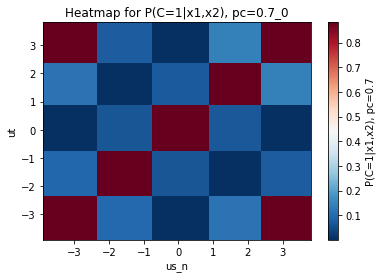

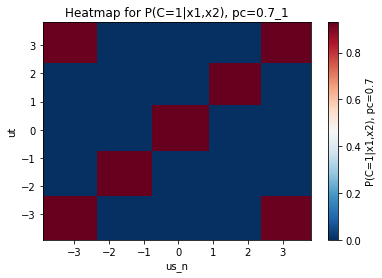

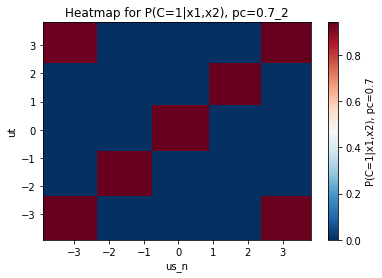

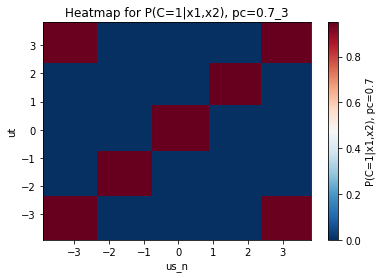

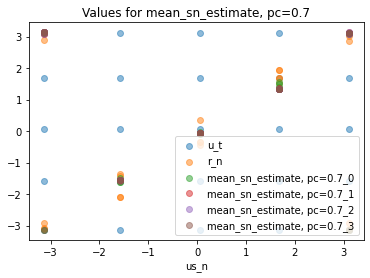

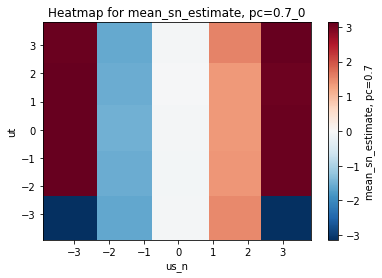

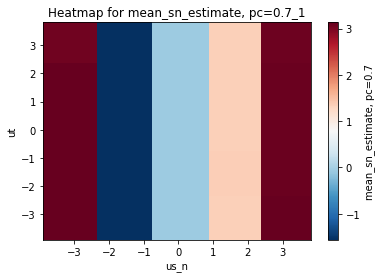

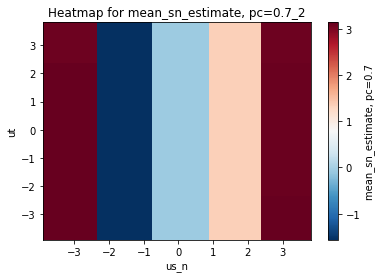

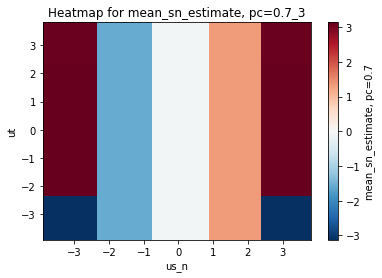

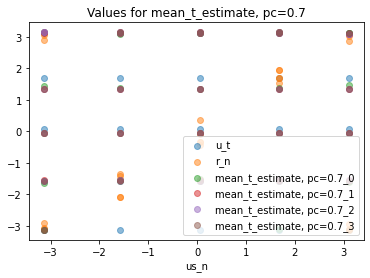

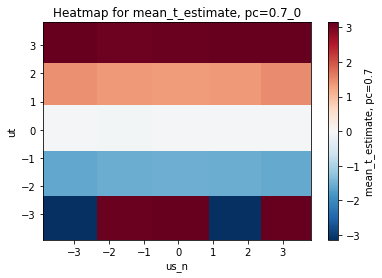

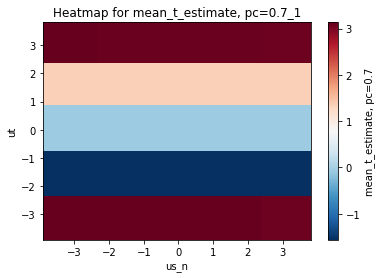

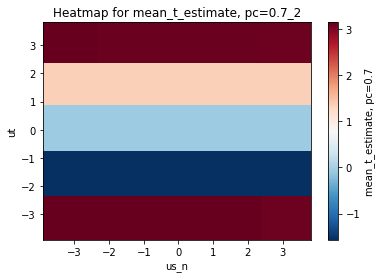

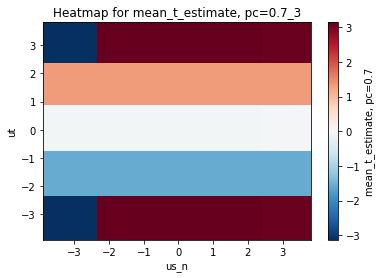

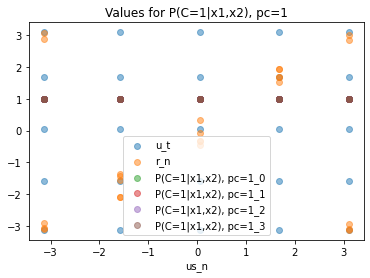

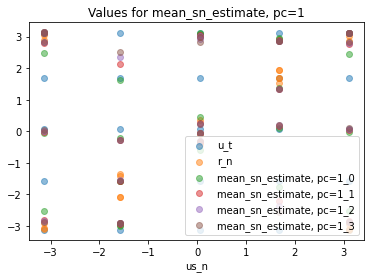

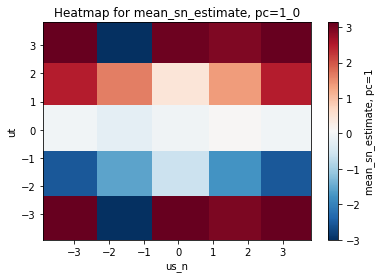

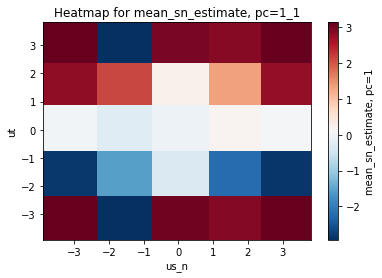

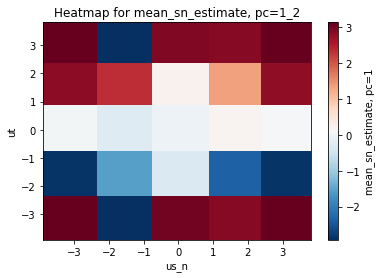

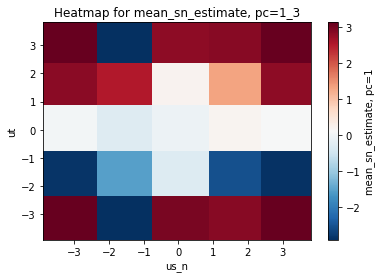

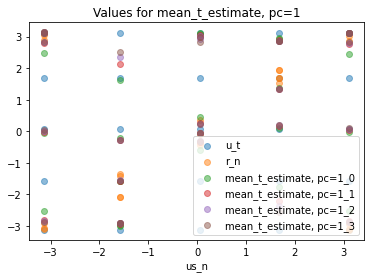

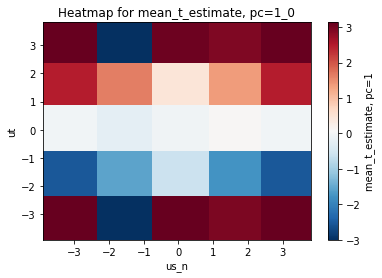

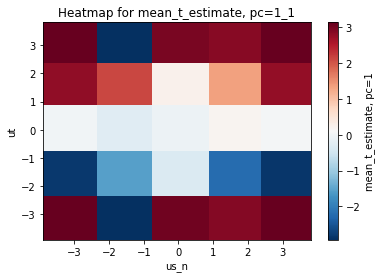

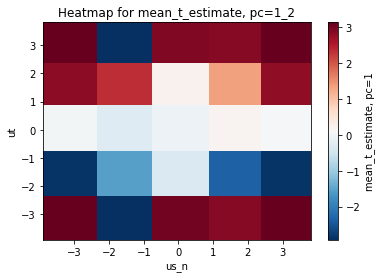

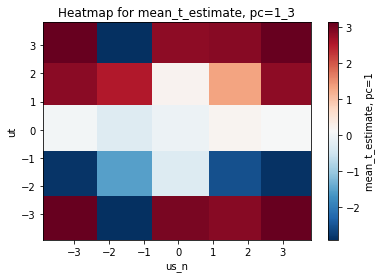

<Figure size 432x288 with 0 Axes>

In [14]:
assert (len(us_n) == mu_x_dim**2)
for i, p_c in enumerate(p_commons):
    plot_heatmap = (p_c < 1) and (p_c > 0)
    plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                    estimate=results['posterior_p_common'][i].mean(axis=0),
                    est_label=f'P(C=1|x1,x2), pc={p_c}', 
                    plot_heatmap=plot_heatmap)
    plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                    estimate=results['mean_sn_est'][i],
                    est_label=f'mean_sn_estimate, pc={p_c}', 
                    plot_heatmap=True)
    plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                    estimate=results['mean_t_est'][i],
                    est_label=f'mean_t_estimate, pc={p_c}', 
                    plot_heatmap=True)